In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import time

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import streamlit as st
from ambient_api.ambientapi import AmbientAPI
from dateutil import parser

<IPython.core.display.Javascript object>

In [3]:
import awn_controller as awn
import storj_df_s3 as sj
import visualization as lo_viz
from log_util import app_logger

<IPython.core.display.Javascript object>

In [4]:
logger = app_logger(__name__)

<IPython.core.display.Javascript object>

In [5]:
AMBIENT_ENDPOINT = st.secrets["AMBIENT_ENDPOINT"]
AMBIENT_API_KEY = st.secrets["AMBIENT_API_KEY"]
AMBIENT_APPLICATION_KEY = st.secrets["AMBIENT_APPLICATION_KEY"]

api = AmbientAPI(
    # log_level="INFO",
    AMBIENT_ENDPOINT=AMBIENT_ENDPOINT,
    AMBIENT_API_KEY=AMBIENT_API_KEY,
    AMBIENT_APPLICATION_KEY=AMBIENT_APPLICATION_KEY,
)

<IPython.core.display.Javascript object>

In [6]:
# define variables
sec_in_hour = 3600 * 1000
bucket = "lookout"

devices = api.get_devices()
device = False

device_menu = "98:CD:AC:22:0D:E5"
file_type = "parquet"
device_mac = device_menu
hist_file = f"{device_mac}.{file_type}"
# lookout/98:CD:AC:22:0D:E5.json

device = devices[0]

<IPython.core.display.Javascript object>

In [7]:
device.info

{'name': 'lookout post',
 'coords': {'geo': {'coordinates': [-123.08386129847136, 44.90142112432992],
   'type': 'Point'},
  'elevation': 137.6079864501953,
  'location': 'Salem',
  'address': '3818 Homestead Rd S, Salem, OR 97302, USA',
  'coords': {'lon': -123.08386129847136, 'lat': 44.90142112432992}}}

<IPython.core.display.Javascript object>

In [8]:
for d in devices:
    print(d.info)

{'name': 'lookout post', 'coords': {'geo': {'coordinates': [-123.08386129847136, 44.90142112432992], 'type': 'Point'}, 'elevation': 137.6079864501953, 'location': 'Salem', 'address': '3818 Homestead Rd S, Salem, OR 97302, USA', 'coords': {'lon': -123.08386129847136, 'lat': 44.90142112432992}}}


<IPython.core.display.Javascript object>

In [9]:
def update_session_data(device, hist_df):
    # todo: convert this to just get interim data.
    """
    Update session with latest historical data and reset session counter.

    :param device: Object representing the device.
    :param hist_df: DataFrame of current historical data.
    :return: None.
    """
    st.session_state["history_df"] = awn.get_history_since_last_archive(device, hist_df)
    st.session_state["session_counter"] = 0

<IPython.core.display.Javascript object>

In [10]:
data = device.get_data()
history_df = awn.load_archive_for_device(device, bucket, file_type)

2025-01-07 11:23:31 - INFO - awn_controller: Load from S3: lookout/98:CD:AC:22:0D:E5.parquet
2025-01-07 11:23:31 - INFO - storj_df_s3: Getting s3://lookout/98:CD:AC:22:0D:E5.parquet


<IPython.core.display.Javascript object>

In [11]:
# Ensure the "date" column is in datetime format
history_df["date"] = pd.to_datetime(history_df["date"])

<IPython.core.display.Javascript object>

In [12]:
# Extract year and day-of-year for year-over-year comparison
history_df["year"] = history_df["date"].dt.year
history_df["day_of_year"] = history_df["date"].dt.dayofyear
# history_df["week_of_year"] = history_df[" date"].dt.weekofyear
history_df["week_of_year"] = history_df["date"].dt.isocalendar().week
# Create a reference year for consistent date formatting
reference_year = 2023
history_df["date_label"] = pd.to_datetime(
    reference_year * 1000 + history_df["day_of_year"], format="%Y%j"
)

<IPython.core.display.Javascript object>

In [13]:
# Group by year and day_of_year, then find the max 'yearlyrainin' per day
daily_max = (
    history_df.groupby(["year", "day_of_year"])["yearlyrainin"].max().reset_index()
)

# Pivot the table so each year is a column
pivot_df = daily_max.pivot(index="day_of_year", columns="year", values="yearlyrainin")

<IPython.core.display.Javascript object>

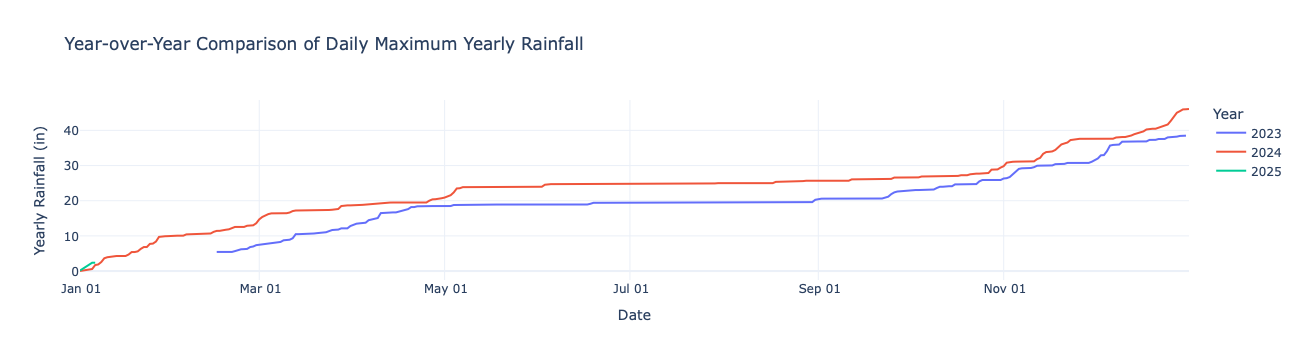

<IPython.core.display.Javascript object>

In [17]:
import pandas as pd
import plotly.graph_objects as go

# Ensure the "date" column is in datetime format
history_df["date"] = pd.to_datetime(history_df["date"])

# Extract year and day-of-year for year-over-year comparison
history_df["year"] = history_df["date"].dt.year
history_df["day_of_year"] = history_df["date"].dt.day_of_year

# Create a reference year for consistent date formatting
reference_year = 2023
history_df["date_label"] = pd.to_datetime(
    reference_year * 1000 + history_df["day_of_year"], format="%Y%j"
)

# Group by year and day_of_year, then find the max 'yearlyrainin' per day
daily_max = (
    history_df.groupby(["year", "day_of_year"])["yearlyrainin"].max().reset_index()
)
daily_max["date_label"] = pd.to_datetime(
    reference_year * 1000 + daily_max["day_of_year"], format="%Y%j"
)

# Create an empty figure
fig = go.Figure()

# Add a trace for each year
for year in daily_max["year"].unique():
    year_data = daily_max[daily_max["year"] == year]
    fig.add_trace(
        go.Scatter(
            x=year_data["date_label"],
            y=year_data["yearlyrainin"],
            mode="lines",
            name=str(year),
        )
    )

# Update layout
fig.update_layout(
    title="Year-over-Year Comparison of Daily Maximum Yearly Rainfall",
    xaxis_title="Date",
    yaxis_title="Yearly Rainfall (in)",
    legend_title="Year",
    xaxis=dict(
        tickformat="%b %d",  # Format x-axis ticks as "Jan 01", "Jun 01", etc.
        ticklabelmode="period",  # Align tick labels for consistent intervals
    ),
    template="plotly_white",
)

# Show the figure
fig.show()

In [16]:
import plotly.graph_objects as go

# Group by year and day_of_year, then find the max values per day for yearlyrainin and dailyrainin
daily_max = (
    history_df.groupby(["year", "day_of_year"])[["yearlyrainin", "dailyrainin"]]
    .max()
    .reset_index()
)
daily_max["date_label"] = pd.to_datetime(
    reference_year * 1000 + daily_max["day_of_year"], format="%Y%j"
)

# Identify the end-of-month data points
end_of_month_data = daily_max[daily_max["date_label"].dt.is_month_end]

# Round rainfall values to tenths
daily_max["yearlyrainin"] = daily_max["yearlyrainin"].round(1)
end_of_month_data["yearlyrainin"] = end_of_month_data["yearlyrainin"].round(1)

# Create a single plot for Yearly Rainfall
fig = go.Figure()

# Add yearlyrainin traces, with labels for end-of-month points
for year in daily_max["year"].unique():
    year_data = daily_max[
        daily_max["year"] == year
    ].copy()  # Avoid SettingWithCopyWarning

    # Generate text labels: Only for end-of-month points, others as None
    year_data["labels"] = [
        yearlyrain if date in end_of_month_data["date_label"].values else None
        for date, yearlyrain in zip(year_data["date_label"], year_data["yearlyrainin"])
    ]

    fig.add_trace(
        go.Scatter(
            x=year_data["date_label"],
            y=year_data["yearlyrainin"],
            mode="lines+text",  # Add text
            text=year_data["labels"],  # Filtered text labels
            textposition="top center",  # Position of labels
            name=f"Yearly Rain ({year})",
        )
    )

# Update layout for better readability
fig.update_layout(
    title="Year-over-Year Comparison of Yearly Rainfall with End-of-Month Labels",
    xaxis=dict(tickformat="%b %d", title="Date"),  # Format as "Jan 01", "Jun 01", etc.
    yaxis=dict(title="Yearly Rainfall (in)"),
    legend_title="Legend",
    template="plotly_white",  # Use default Plotly template
    # height=600,  # Adjust the height for a single chart
)

# Show the figure
fig.show()

/var/folders/cs/np0g1lv14gj9kdhhvq53x0q00000gn/T/ipykernel_30353/2161198898.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>